In [1]:
%matplotlib inline
import cupy as cp
from cuml.feature_extraction.text import HashingVectorizer
from dask_cuda import LocalCUDACluster
from dask.distributed import Client, wait
from cuml.dask.common import to_sparse_dask_array
from cuml.dask.feature_extraction.text import TfidfTransformer
import dask_cudf
import cudf
import nltk
import dask
from timeit import default_timer as timer
import time
import pickle
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class SimpleTimer:
    def __init__(self):
        self.start = None
        self.end = None
        self.elapsed = None

    def __enter__(self):
        self.start = time.perf_counter_ns()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time.perf_counter_ns()
        self.elapsed = self.end - self.start

def visualize_data(path):

    data = pickle.load(open(path, "rb"))
    df_list = [["n_workers", "sample_run", "overall", "data_read", "data_preprocessing", "hashing_vectorizer", "tfidf_transformer", "nrows"]]
    for n_workers in data:
        temp_data = data[n_workers]
        if isinstance(temp_data, float):
            continue
        results = temp_data["sample_run_results"]
        for sample_run in range(len(results)):
            timings = results[sample_run]
            df_list.append([n_workers, sample_run, timings["overall"]/1e9, 
                           timings["data_read"]/1e9, timings["data_preprocessing"]/1e9,timings["hashing_vectorizer"]/1e9, 
                           timings["tfidf_transformer"]/1e9, timings["nrows"]])
    
    perf_df = pd.DataFrame(df_list[1:], columns=df_list[0])
    fig=plt.figure(figsize=(12,8), dpi= 100, facecolor='w', edgecolor='k')
    dd = pd.melt(perf_df, 
                 id_vars=['n_workers'],
                 value_vars=['overall','data_read', 'data_preprocessing', 'hashing_vectorizer','tfidf_transformer'],
                 var_name='latency')
    sns.boxplot(x='latency',y='value',data=dd, orient="v", hue="n_workers")
    plt.show()
    return perf_df, dd 

In [3]:
nltk.download('stopwords')
STOPWORDS = nltk.corpus.stopwords.words('english')
PUNCTUATIONS = [ '!', '"', '#', '$', '%', '&', '(', ')', '*', '+', '-', '.', '/',  '\\', ':', ';', '<', '=', '>',
           '?', '@', '[', ']', '^', '_', '`', '{', '|', '}', '\t','\n',"'",",",'~' , '—']

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# Create a local CUDA cluster
cluster = LocalCUDACluster(CUDA_VISIBLE_DEVICES="2,3,4,5,6,7")
client = Client(cluster)

In [5]:
client

Connection method: Cluster object,Cluster type: LocalCUDACluster
Dashboard: http://127.0.0.1:8787/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:8787/status,Workers: 6
Total threads: 6,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:33161,Workers: 6
Dashboard: http://127.0.0.1:8787/status,Total threads: 6
Started: Just now,Total memory: 0.98 TiB
Comm: tcp://127.0.0.1:41649,Total threads: 1
Dashboard: http://127.0.0.1:39335/status,Memory: 167.97 GiB
Nanny: tcp://127.0.0.1:45891,


## Helper Functions

In [6]:
def scale_workers(client, n_workers, timeout=300):
    client.cluster.scale(n_workers)
    
    m = len(client.has_what().keys())    
    start = end = time.perf_counter_ns()
    while ((m != n_workers) and (((end - start) / 1e9) < timeout) ):
        time.sleep(5)
        m = len(client.has_what().keys())
        
        end = time.perf_counter_ns()
        
    if (((end - start) / 1e9) >= timeout):
        raise RuntimeError(f"Failed to rescale cluster in {timeout} sec."
              "Try increasing timeout for very large containers, and verify available compute resources.")

def read_data(client, parquet_path, persist_flag=True):
    data = dask_cudf.read_parquet(parquet_path)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
    return data

def text_preprocessor(data, client, column_name, PUNCTUATIONS, STOPWORDS, persist_flag=True):
    data = data[data[column_name].notnull()]
    data[column_name] = (data[column_name]
                         .str.lower()
                         .str.replace(PUNCTUATIONS, [" "]*len(PUNCTUATIONS), regex=False)
                         .str.replace_tokens(STOPWORDS, "")
                         .str.normalize_spaces()
                         .str.strip())
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            data = client.persist(data)
        wait(data)
    
    return data

def hashing_vectorizer(data, client, column_name, persist_flag):
    vectorizer = HashingVectorizer(stop_words='english', preprocessor=None)
    # Meta is an empty dataframe matches the dtypes and columns of the output
    meta = dask.array.from_array(cp.sparse.csr_matrix(cp.zeros(1, dtype=cp.float32))) 
    hashing_vectorized = data[column_name].map_partitions(vectorizer.fit_transform, meta=meta).astype(cp.float32)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            hashing_vectorized = client.persist(hashing_vectorized)
        wait(hashing_vectorized)
        hashing_vectorized.compute_chunk_sizes()
    return hashing_vectorized

def tfidf_transformer(data, client, persist_flag):
    multi_gpu_transformer = TfidfTransformer()
    result = multi_gpu_transformer.fit_transform(data)
    if persist_flag:
        with dask.annotate(workers=set(client.has_what().keys())):
            result = client.persist(result)
        wait(result)
        result.compute_chunk_sizes()
    return result

def execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path="./results.pkl", persist_flag=True):
    sample_record = {"overall":0, "data_read":0, "hashing_vectorizer":0, "tfid_transformer":0, "data_preprocessing":0, "nrows":0}
    with SimpleTimer() as timer:
        data = read_data(client, parquet_path, persist_flag)
    sample_record["data_read"]=timer.elapsed

    with SimpleTimer() as timer:
        data = text_preprocessor(data, client, "review_body", PUNCTUATIONS, STOPWORDS, persist_flag)
    sample_record["data_preprocessing"]=timer.elapsed
    
    with SimpleTimer() as timer:
        hashing_vectorized = hashing_vectorizer(data, client, "review_body", persist_flag)
    sample_record["hashing_vectorizer"]=timer.elapsed
    
    with SimpleTimer() as timer:
        result = tfidf_transformer(hashing_vectorized, client, persist_flag=True)
    sample_record["tfidf_transformer"]=timer.elapsed
    
    print(f"Workers:{n}, Sample Run:{i}, Finished loading data in {sample_record['data_read']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished preprocessing data in {sample_record['data_preprocessing']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting HashVectorizer in {sample_record['hashing_vectorizer']}s")
    print(f"Workers:{n}, Sample Run:{i}, Finished fitting IDF Transformer in {sample_record['tfidf_transformer']}s")
    return data, result, sample_record
    
def performance_numbers(client, parquet_path, worker_counts=[1], samples=1, result_path="./results.pkl", persist_flag=True):
    """
    Main function to perform the performance sweep
    """
        
    overall_perf_result = {}
    
    for n in worker_counts: 
        overall_perf_result[n]={"sample_run_results": []}
        scale_workers(client, n)
        
        for i in tqdm(range(samples)): 
            with SimpleTimer() as overalltimer:
                data, result, sample_record = execute_full_pipeline(n, i, client, parquet_path, worker_counts=[1], result_path=result_path, persist_flag=persist_flag)
            sample_record["overall"]=overalltimer.elapsed
            sample_record["nrows"]=data.shape[0].compute()
            print(f"Workers:{n}, Sample Run:{i}, Finished executing full pipeline in {overalltimer.elapsed}s")
            overall_perf_result[n]["sample_run_results"].append(sample_record)
    
    with open(result_path, "wb") as file:
        pickle.dump(overall_perf_result, file)
    

In [7]:
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 5
worker_counts = [2,4,6]
result_path = f"./results/result_poc_nlp_dask_{dataset}_persist.pkl"

In [8]:
%%time
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=True)

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:11:20.616740] [Delayed('_merge_stats_to_model-951c844e-6143-43fe-8635-da961f082a9f')]
[I] [21:11:20.620283] [Delayed('_merge_stats_to_model-8d65b9cc-17f8-401a-bf9d-7f4b95cd587b')]
[I] [21:11:20.677664] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-951c844e-6143-43fe-8635-da961f082a9f>]
[I] [21:11:20.677890] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8d65b9cc-17f8-401a-bf9d-7f4b95cd587b>]
[I] [21:11:20.686756] [Delayed('_merge_stats_to_model-3980ab3b-b797-4a83-be7c-db2e6bdf3809')]


 20%|██        | 1/5 [00:21<01:24, 21.14s/it]

Workers:2, Sample Run:0, Finished loading data in 3836258267s
Workers:2, Sample Run:0, Finished preprocessing data in 8751527896s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 7936648223s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 568127656s
Workers:2, Sample Run:0, Finished executing full pipeline in 21094392493s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:11:36.755819] [Delayed('_merge_stats_to_model-6541ea00-f5b8-421a-9bb0-6d7b0054538b')]
[I] [21:11:36.758914] [Delayed('_merge_stats_to_model-4d1d7cec-a25c-47c1-91fb-f3f6e301b0f0')]
[I] [21:11:36.807082] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6541ea00-f5b8-421a-9bb0-6d7b0054538b>]
[I] [21:11:36.807330] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4d1d7cec-a25c-47c1-91fb-f3f6e301b0f0>]
[I] [21:11:36.815699] [Delayed('_merge_stats_to_model-90bb826f-50df-4e9c-a89c-68c7f36c48aa')]


 40%|████      | 2/5 [00:37<00:54, 18.22s/it]

Workers:2, Sample Run:1, Finished loading data in 874755282s
Workers:2, Sample Run:1, Finished preprocessing data in 8262856175s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 6348889360s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 558898811s
Workers:2, Sample Run:1, Finished executing full pipeline in 16047618668s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:11:53.445845] [Delayed('_merge_stats_to_model-140975ad-1e01-4486-b6ef-49f2b0d81bb6')]
[I] [21:11:53.448356] [Delayed('_merge_stats_to_model-2a41ca09-e1d1-4643-b493-b2a84277e1ed')]
[I] [21:11:53.498724] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-140975ad-1e01-4486-b6ef-49f2b0d81bb6>]
[I] [21:11:53.498972] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2a41ca09-e1d1-4643-b493-b2a84277e1ed>]
[I] [21:11:53.507428] [Delayed('_merge_stats_to_model-8af5e9fd-9118-4bbf-bd3e-7f9c5b550759')]


 60%|██████    | 3/5 [00:54<00:35, 17.52s/it]

Workers:2, Sample Run:2, Finished loading data in 878809486s
Workers:2, Sample Run:2, Finished preprocessing data in 8641134724s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 6498306737s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 550993451s
Workers:2, Sample Run:2, Finished executing full pipeline in 16572217560s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:12:09.561690] [Delayed('_merge_stats_to_model-0c432647-34a6-4375-816d-859c80be004a')]
[I] [21:12:09.564106] [Delayed('_merge_stats_to_model-b22be531-5e77-410e-9316-c48f1c233fc8')]
[I] [21:12:09.610670] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0c432647-34a6-4375-816d-859c80be004a>]
[I] [21:12:09.610924] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b22be531-5e77-410e-9316-c48f1c233fc8>]
[I] [21:12:09.619678] [Delayed('_merge_stats_to_model-b6eafd88-fbb5-468e-b62c-8283ad65faff')]


 80%|████████  | 4/5 [01:10<00:16, 16.96s/it]

Workers:2, Sample Run:3, Finished loading data in 864396747s
Workers:2, Sample Run:3, Finished preprocessing data in 8255356983s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 6311989731s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 549634505s
Workers:2, Sample Run:3, Finished executing full pipeline in 15983197998s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:12:26.220590] [Delayed('_merge_stats_to_model-17a38308-f86c-48e1-a6d7-35f869f19d2c')]
[I] [21:12:26.223079] [Delayed('_merge_stats_to_model-57b996ea-55e9-49af-ba1c-2007b408c85f')]
[I] [21:12:26.277366] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-17a38308-f86c-48e1-a6d7-35f869f19d2c>]
[I] [21:12:26.277623] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-57b996ea-55e9-49af-ba1c-2007b408c85f>]
[I] [21:12:26.286126] [Delayed('_merge_stats_to_model-fbadddfb-619b-435e-aedc-fad104a8899e')]


100%|██████████| 5/5 [01:26<00:00, 17.36s/it]

Workers:2, Sample Run:4, Finished loading data in 878632903s
Workers:2, Sample Run:4, Finished preprocessing data in 8623719191s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 6481921313s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 562618237s
Workers:2, Sample Run:4, Finished executing full pipeline in 16548716988s



  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:12:44.024712] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-086558e2-d170-4fbd-9da9-8ffe3f383454>]
[I] [21:12:44.025807] [Delayed('_merge_stats_to_model-aeefc99a-8571-41bb-b0b9-a6af9a6294c2')]
[I] [21:12:44.027428] [Delayed('_merge_stats_to_model-03d11087-67b2-4389-8105-14e9eb92f816')]
[I] [21:12:44.028892] [Delayed('_merge_stats_to_model-741d8672-b530-40d3-86a3-3e5874aa99a3')]
[I] [21:12:44.064122] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-086558e2-d170-4fbd-9da9-8ffe3f383454>]
[I] [21:12:44.064363] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-aeefc99a-8571-41bb-b0b9-a6af9a6294c2>]
[I] [21:12:44.064549] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-03d11087-67b2-4389-8105-14e9eb92f816>]
[I] [21:12:44.064707] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-741d8672-b530-40d3-86a3-3e5874aa99a3>]
[I] [21:12:44.074009] [Delayed('_merge

 20%|██        | 1/5 [00:13<00:52, 13.03s/it]

Workers:4, Sample Run:0, Finished loading data in 1456979344s
Workers:4, Sample Run:0, Finished preprocessing data in 5933629229s
Workers:4, Sample Run:0, Finished fitting HashVectorizer in 4569148741s
Workers:4, Sample Run:0, Finished fitting IDF Transformer in 943369306s
Workers:4, Sample Run:0, Finished executing full pipeline in 12905814312s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:12:53.671685] [Delayed('_merge_stats_to_model-50032017-c332-4747-a257-941fda12dfa0')]
[I] [21:12:53.673448] [Delayed('_merge_stats_to_model-70cb120f-51f2-4387-8f4e-ed876133e1b9')]
[I] [21:12:53.674410] [Delayed('_merge_stats_to_model-c211f595-5620-44c9-935b-3644b0d4fd53')]
[I] [21:12:53.675274] [Delayed('_merge_stats_to_model-bea06161-079c-406c-8bb4-4b1ec43e3b3e')]
[I] [21:12:53.716301] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-50032017-c332-4747-a257-941fda12dfa0>]
[I] [21:12:53.716558] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-70cb120f-51f2-4387-8f4e-ed876133e1b9>]
[I] [21:12:53.716726] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c211f595-5620-44c9-935b-3644b0d4fd53>]
[I] [21:12:53.716885] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-bea06161-079c-406c-8bb4-4b1ec43e3b3e>]
[I] [21:12:53.726370] [Delayed('_merge_stats_to_model-e48581dd-3706

 40%|████      | 2/5 [00:22<00:32, 10.78s/it]

Workers:4, Sample Run:1, Finished loading data in 564756307s
Workers:4, Sample Run:1, Finished preprocessing data in 4426486413s
Workers:4, Sample Run:1, Finished fitting HashVectorizer in 3707768353s
Workers:4, Sample Run:1, Finished fitting IDF Transformer in 365219696s
Workers:4, Sample Run:1, Finished executing full pipeline in 9067376207s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:02.745496] [Delayed('_merge_stats_to_model-a2deb53a-c86c-4b84-a9c4-a37141313212')]
[I] [21:13:02.747505] [Delayed('_merge_stats_to_model-ce488c99-8447-47e1-befb-c0624f2eb2d5')]
[I] [21:13:02.748261] [Delayed('_merge_stats_to_model-d7b76878-92d1-4b98-87da-596ecfa6a6c7')]
[I] [21:13:02.749668] [Delayed('_merge_stats_to_model-8ae715d3-3bfa-465e-a569-aaa8abb8c650')]
[I] [21:13:02.788404] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a2deb53a-c86c-4b84-a9c4-a37141313212>]
[I] [21:13:02.788657] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ce488c99-8447-47e1-befb-c0624f2eb2d5>]
[I] [21:13:02.788858] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-d7b76878-92d1-4b98-87da-596ecfa6a6c7>]
[I] [21:13:02.789057] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8ae715d3-3bfa-465e-a569-aaa8abb8c650>]
[I] [21:13:02.798416] [Delayed('_merge_stats_to_model-1ba82697-bed3

 60%|██████    | 3/5 [00:31<00:20, 10.07s/it]

Workers:4, Sample Run:2, Finished loading data in 571509892s
Workers:4, Sample Run:2, Finished preprocessing data in 4405024138s
Workers:4, Sample Run:2, Finished fitting HashVectorizer in 3607479172s
Workers:4, Sample Run:2, Finished fitting IDF Transformer in 504917690s
Workers:4, Sample Run:2, Finished executing full pipeline in 9091205039s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:12.802660] [Delayed('_merge_stats_to_model-4f739e29-34cf-4587-b8f2-e3b78b5f5a18')]
[I] [21:13:12.804275] [Delayed('_merge_stats_to_model-13789467-2bfe-4b9b-9992-b7585822dece')]
[I] [21:13:12.805148] [Delayed('_merge_stats_to_model-e296e946-27d3-46f7-9128-4c2bdde0129c')]
[I] [21:13:12.805930] [Delayed('_merge_stats_to_model-0c79d9ac-9661-4b0f-804f-b3e4a507fcd9')]
[I] [21:13:12.846854] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4f739e29-34cf-4587-b8f2-e3b78b5f5a18>]
[I] [21:13:12.847107] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-13789467-2bfe-4b9b-9992-b7585822dece>]
[I] [21:13:12.847277] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e296e946-27d3-46f7-9128-4c2bdde0129c>]
[I] [21:13:12.847435] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0c79d9ac-9661-4b0f-804f-b3e4a507fcd9>]
[I] [21:13:12.856761] [Delayed('_merge_stats_to_model-1a286539-fa32

 80%|████████  | 4/5 [00:41<00:10, 10.07s/it]

Workers:4, Sample Run:3, Finished loading data in 572466945s
Workers:4, Sample Run:3, Finished preprocessing data in 4965944550s
Workers:4, Sample Run:3, Finished fitting HashVectorizer in 3846342578s
Workers:4, Sample Run:3, Finished fitting IDF Transformer in 531889412s
Workers:4, Sample Run:3, Finished executing full pipeline in 9918375131s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:22.064595] [Delayed('_merge_stats_to_model-2a66561d-ee1e-466e-84f5-4b0f3defefb8')]
[I] [21:13:22.066133] [Delayed('_merge_stats_to_model-a7203e80-2310-45e1-b29f-69696fc6a290')]
[I] [21:13:22.066968] [Delayed('_merge_stats_to_model-ac1c6342-01ac-485c-94db-3abcf31ff884')]
[I] [21:13:22.067819] [Delayed('_merge_stats_to_model-5ba199ee-eceb-4d46-b28b-82bcbe9d4998')]
[I] [21:13:22.107248] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2a66561d-ee1e-466e-84f5-4b0f3defefb8>]
[I] [21:13:22.107500] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a7203e80-2310-45e1-b29f-69696fc6a290>]
[I] [21:13:22.107727] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ac1c6342-01ac-485c-94db-3abcf31ff884>]
[I] [21:13:22.107949] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-5ba199ee-eceb-4d46-b28b-82bcbe9d4998>]
[I] [21:13:22.117350] [Delayed('_merge_stats_to_model-7a5c086a-c6ac

100%|██████████| 5/5 [00:50<00:00, 10.15s/it]

Workers:4, Sample Run:4, Finished loading data in 546003665s
Workers:4, Sample Run:4, Finished preprocessing data in 4453400824s
Workers:4, Sample Run:4, Finished fitting HashVectorizer in 3599843674s
Workers:4, Sample Run:4, Finished fitting IDF Transformer in 502600765s
Workers:4, Sample Run:4, Finished executing full pipeline in 9103399498s



  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:37.342162] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-990dda14-77aa-47f6-a7d9-7a747fec1967>]
[I] [21:13:37.342524] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1a81eea3-f68d-4fca-8f3b-3536605ae950>]
[I] [21:13:37.343375] [Delayed('_merge_stats_to_model-59092988-ff18-44c5-bff8-49f1f863ce50')]
[I] [21:13:37.344910] [Delayed('_merge_stats_to_model-98780b50-29ec-4955-9572-51cda7594384')]
[I] [21:13:37.345173] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-d91322e4-1115-4390-8338-326dd01cc638>]
[I] [21:13:37.345852] [Delayed('_merge_stats_to_model-38b4bd10-f6a2-417e-8fa2-fa489d683306')]
[I] [21:13:37.381339] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-990dda14-77aa-47f6-a7d9-7a747fec1967>]
[I] [21:13:37.381449] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1a81eea3-f68d-4fca-8f3b-3536605ae950>]
[I] [21:13:37.381759] [<Future: finished, type: cuml.TfidfT

 20%|██        | 1/5 [00:10<00:41, 10.37s/it]

Workers:6, Sample Run:0, Finished loading data in 1527009925s
Workers:6, Sample Run:0, Finished preprocessing data in 4476969191s
Workers:6, Sample Run:0, Finished fitting HashVectorizer in 3496920699s
Workers:6, Sample Run:0, Finished fitting IDF Transformer in 729361414s
Workers:6, Sample Run:0, Finished executing full pipeline in 10231859258s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:44.496340] [Delayed('_merge_stats_to_model-72d07293-4cea-4e84-8833-7786382caac6')]
[I] [21:13:44.497290] [Delayed('_merge_stats_to_model-96b71e35-c8fa-42ca-89c0-be7daad0a24c')]
[I] [21:13:44.498071] [Delayed('_merge_stats_to_model-6702ad67-902c-4ed6-947f-bcc1241ae6d6')]
[I] [21:13:44.498934] [Delayed('_merge_stats_to_model-34f561fd-2222-4f6f-bee0-d498513d351c')]
[I] [21:13:44.499186] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4ad680e2-7832-40af-bbd4-93b668911cb0>]
[I] [21:13:44.499440] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-f8b956b6-3013-4e66-a3fc-2cf1d0c96dcb>]
[I] [21:13:44.522625] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-72d07293-4cea-4e84-8833-7786382caac6>]
[I] [21:13:44.522888] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-96b71e35-c8fa-42ca-89c0-be7daad0a24c>]
[I] [21:13:44.523051] [<Future: finished, type: cuml.TfidfTransformer, key: _merg

 40%|████      | 2/5 [00:17<00:24,  8.28s/it]

Workers:6, Sample Run:1, Finished loading data in 438188930s
Workers:6, Sample Run:1, Finished preprocessing data in 3218248804s
Workers:6, Sample Run:1, Finished fitting HashVectorizer in 2652726346s
Workers:6, Sample Run:1, Finished fitting IDF Transformer in 358587348s
Workers:6, Sample Run:1, Finished executing full pipeline in 6670172307s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:51.569818] [Delayed('_merge_stats_to_model-8cb2a3e1-1997-41aa-bb1b-a691e925530d')]
[I] [21:13:51.570757] [Delayed('_merge_stats_to_model-38896cfc-14bc-464b-9c36-04c03311dad9')]
[I] [21:13:51.571640] [Delayed('_merge_stats_to_model-6e67a1ff-56b6-4e82-bd67-f7f06b93ce30')]
[I] [21:13:51.572441] [Delayed('_merge_stats_to_model-77133795-02bf-4776-a35c-1ac015e1e3f2')]
[I] [21:13:51.572705] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3661c576-a4c8-4bd7-b018-1855d86b9d5e>]
[I] [21:13:51.572895] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-dce9c82d-55e4-4dbb-b037-dc4ca469d737>]
[I] [21:13:51.597059] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8cb2a3e1-1997-41aa-bb1b-a691e925530d>]
[I] [21:13:51.597333] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-38896cfc-14bc-464b-9c36-04c03311dad9>]
[I] [21:13:51.597522] [<Future: finished, type: cuml.TfidfTransformer, key: _merg

 60%|██████    | 3/5 [00:24<00:15,  7.73s/it]

Workers:6, Sample Run:2, Finished loading data in 446085941s
Workers:6, Sample Run:2, Finished preprocessing data in 3460643669s
Workers:6, Sample Run:2, Finished fitting HashVectorizer in 2663871940s
Workers:6, Sample Run:2, Finished fitting IDF Transformer in 354393863s
Workers:6, Sample Run:2, Finished executing full pipeline in 6927808869s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:13:58.993318] [Delayed('_merge_stats_to_model-9aa7dbc1-650b-4991-981a-67ae38501850')]
[I] [21:13:58.994201] [Delayed('_merge_stats_to_model-45df32a2-d871-4913-bf7b-a4b2f64dd2b9')]
[I] [21:13:58.994940] [Delayed('_merge_stats_to_model-e04975eb-a6eb-4289-b3b8-f0aeda56c9cf')]
[I] [21:13:58.995867] [Delayed('_merge_stats_to_model-9f6a9455-c7a9-45a7-9140-27b2d1821f6f')]
[I] [21:13:58.996125] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-979b1c65-f868-4911-ab18-efbaf7fe0cd5>]
[I] [21:13:58.996318] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-09961b48-1216-4d7c-8ddd-bf1e3a2d150b>]
[I] [21:13:59.020453] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-9aa7dbc1-650b-4991-981a-67ae38501850>]
[I] [21:13:59.020716] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-45df32a2-d871-4913-bf7b-a4b2f64dd2b9>]
[I] [21:13:59.020889] [<Future: finished, type: cuml.TfidfTransformer, key: _merg

 80%|████████  | 4/5 [00:31<00:07,  7.61s/it]

Workers:6, Sample Run:3, Finished loading data in 445659067s
Workers:6, Sample Run:3, Finished preprocessing data in 3656023699s
Workers:6, Sample Run:3, Finished fitting HashVectorizer in 2805765609s
Workers:6, Sample Run:3, Finished fitting IDF Transformer in 366014294s
Workers:6, Sample Run:3, Finished executing full pipeline in 7276801492s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:14:06.339681] [Delayed('_merge_stats_to_model-ab9e4acc-0d3f-4e0f-b902-920f8ac650e3')]
[I] [21:14:06.340738] [Delayed('_merge_stats_to_model-3fab27f0-1000-44b0-82b4-a15205927af0')]
[I] [21:14:06.341005] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-958417a1-d4d4-4266-aca1-6eed1ca83639>]
[I] [21:14:06.341852] [Delayed('_merge_stats_to_model-d521b448-9898-4a1f-ba6f-3dab83be61b8')]
[I] [21:14:06.342137] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-9eebec09-1485-414d-8671-a5a6393beefc>]
[I] [21:14:06.342837] [Delayed('_merge_stats_to_model-26de5a0c-a2dd-418b-bde3-ea970f72986c')]
[I] [21:14:06.365498] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ab9e4acc-0d3f-4e0f-b902-920f8ac650e3>]
[I] [21:14:06.365894] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-3fab27f0-1000-44b0-82b4-a15205927af0>]
[I] [21:14:06.366079] [<Future: finished, type: cuml.TfidfTransformer, key: _set_

100%|██████████| 5/5 [00:39<00:00,  7.83s/it]

Workers:6, Sample Run:4, Finished loading data in 443111821s
Workers:6, Sample Run:4, Finished preprocessing data in 3588091951s
Workers:6, Sample Run:4, Finished fitting HashVectorizer in 2798549002s
Workers:6, Sample Run:4, Finished fitting IDF Transformer in 492002393s
Workers:6, Sample Run:4, Finished executing full pipeline in 7323371219s
CPU times: user 13.5 s, sys: 2.2 s, total: 15.7 s
Wall time: 3min 11s


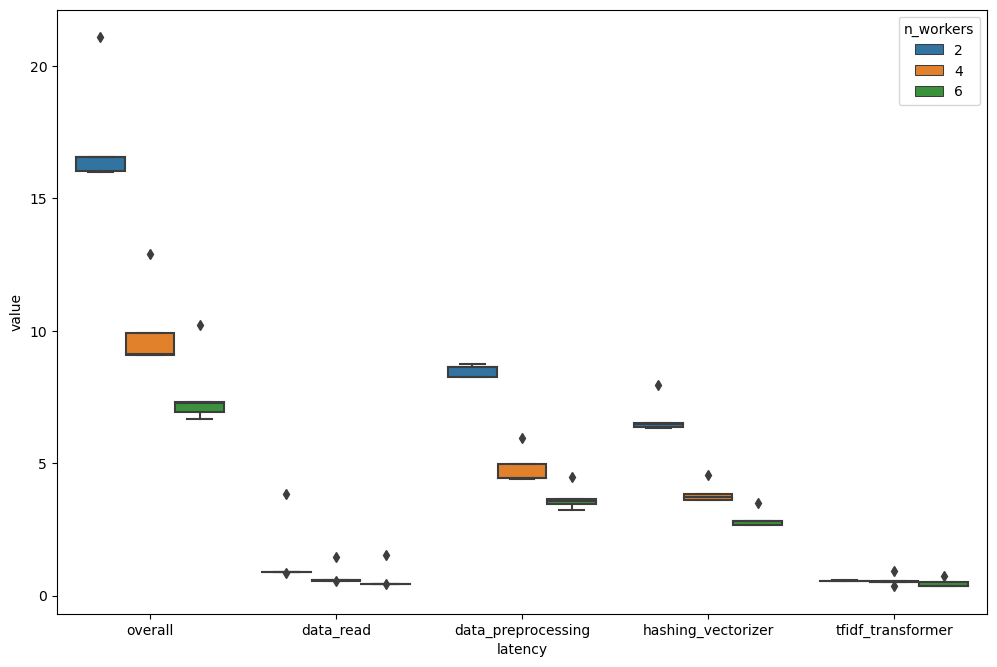

In [9]:
data, melt_data = visualize_data(result_path)        

In [10]:
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])

In [11]:
groupy

sample_run                    overall                 data_read  \
                mean       std count       mean       std count      mean   
n_workers                                                                   
2                  2  1.581139     5  17.249229  2.166855     5  1.466571   
4                  2  1.581139     5  10.017234  1.654428     5  0.742343   
6                  2  1.581139     5   7.686003  1.448025     5  0.660011   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          1.324709     5           8.506919  ...     5           6.715551   
4          0.399635     5           4.836897  ...     5           3.866117   
6          0.484677     5           3.679995  ...     5           2.883567   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
2          0.687415     5          0.558055  0.007806     5  7004147  0.0   
4          0.405436     5          0.569599  0.218843     5  7004147  0.0   
6          0.350370     5          0.460072  0.161129     5  7004147  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  

[3 rows x 21 columns]

### We can run the exact same pipeline without the intermediate persists. This is slower. 

  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:14:28.667761] [Delayed('_merge_stats_to_model-e4437ef9-d817-4da4-a843-a4e202749135')]
[I] [21:14:28.670411] [Delayed('_merge_stats_to_model-a6bd9a8e-4090-4110-9cc3-d8f680a58887')]
[I] [21:14:28.717703] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e4437ef9-d817-4da4-a843-a4e202749135>]
[I] [21:14:28.717964] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a6bd9a8e-4090-4110-9cc3-d8f680a58887>]
[I] [21:14:28.726523] [Delayed('_merge_stats_to_model-a8c1276e-afdf-4d8a-ad64-833ec5b250a4')]
Workers:2, Sample Run:0, Finished loading data in 24150732s
Workers:2, Sample Run:0, Finished preprocessing data in 30941925s
Workers:2, Sample Run:0, Finished fitting HashVectorizer in 3645994s
Workers:2, Sample Run:0, Finished fitting IDF Transformer in 31935930429s


 20%|██        | 1/5 [00:41<02:47, 41.88s/it]

Workers:2, Sample Run:0, Finished executing full pipeline in 31994872707s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:15:10.544182] [Delayed('_merge_stats_to_model-0e21969a-55af-403f-846e-25a1bb308909')]
[I] [21:15:10.546827] [Delayed('_merge_stats_to_model-2526191f-7df5-4597-8445-cce6b8a973cb')]
[I] [21:15:10.600381] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0e21969a-55af-403f-846e-25a1bb308909>]
[I] [21:15:10.600637] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2526191f-7df5-4597-8445-cce6b8a973cb>]
[I] [21:15:10.609299] [Delayed('_merge_stats_to_model-7aae5e5d-a11a-418e-94a2-def874bf54f8')]
Workers:2, Sample Run:1, Finished loading data in 17902858s
Workers:2, Sample Run:1, Finished preprocessing data in 25387529s
Workers:2, Sample Run:1, Finished fitting HashVectorizer in 3124122s
Workers:2, Sample Run:1, Finished fitting IDF Transformer in 32533726952s


 40%|████      | 2/5 [01:24<02:06, 42.24s/it]

Workers:2, Sample Run:1, Finished executing full pipeline in 32581194269s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:15:53.039806] [Delayed('_merge_stats_to_model-a35623c2-8378-4395-b04f-60675054f500')]
[I] [21:15:53.043139] [Delayed('_merge_stats_to_model-c337b121-73d9-4fbf-bf32-429403a0d3d9')]
[I] [21:15:53.089764] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a35623c2-8378-4395-b04f-60675054f500>]
[I] [21:15:53.090022] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c337b121-73d9-4fbf-bf32-429403a0d3d9>]
[I] [21:15:53.098714] [Delayed('_merge_stats_to_model-fb33748a-a34e-4c91-a079-9314c22b587a')]
Workers:2, Sample Run:2, Finished loading data in 20376216s
Workers:2, Sample Run:2, Finished preprocessing data in 24299761s
Workers:2, Sample Run:2, Finished fitting HashVectorizer in 2942811s
Workers:2, Sample Run:2, Finished fitting IDF Transformer in 32410626319s


 60%|██████    | 3/5 [02:06<01:24, 42.30s/it]

Workers:2, Sample Run:2, Finished executing full pipeline in 32460457641s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:16:35.432293] [Delayed('_merge_stats_to_model-a865c792-8bf4-4655-a2e4-ce80baea9bd6')]
[I] [21:16:35.435106] [Delayed('_merge_stats_to_model-7e09b0ee-6d92-404e-91fd-f2fd647ca529')]
[I] [21:16:35.481574] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-a865c792-8bf4-4655-a2e4-ce80baea9bd6>]
[I] [21:16:35.481829] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-7e09b0ee-6d92-404e-91fd-f2fd647ca529>]
[I] [21:16:35.490298] [Delayed('_merge_stats_to_model-c6cc4779-3c39-4845-a74f-30c28172a977')]
Workers:2, Sample Run:3, Finished loading data in 21019148s
Workers:2, Sample Run:3, Finished preprocessing data in 24086181s
Workers:2, Sample Run:3, Finished fitting HashVectorizer in 3126296s
Workers:2, Sample Run:3, Finished fitting IDF Transformer in 32509405244s


 80%|████████  | 4/5 [02:49<00:42, 42.37s/it]

Workers:2, Sample Run:3, Finished executing full pipeline in 32558767986s


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:17:18.057070] [Delayed('_merge_stats_to_model-5e1bfa6c-3bcd-4c64-8c7a-c2128a720885')]
[I] [21:17:18.059637] [Delayed('_merge_stats_to_model-0aa3584f-66e5-4415-819d-864f9968a0de')]
[I] [21:17:18.112496] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-5e1bfa6c-3bcd-4c64-8c7a-c2128a720885>]
[I] [21:17:18.112754] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-0aa3584f-66e5-4415-819d-864f9968a0de>]
[I] [21:17:18.121516] [Delayed('_merge_stats_to_model-827cb389-29a2-4a8c-be07-4a0c20bf1319')]
Workers:2, Sample Run:4, Finished loading data in 19907439s
Workers:2, Sample Run:4, Finished preprocessing data in 189760638s
Workers:2, Sample Run:4, Finished fitting HashVectorizer in 3617075s
Workers:2, Sample Run:4, Finished fitting IDF Transformer in 32486322672s


100%|██████████| 5/5 [03:31<00:00, 42.28s/it]

Workers:2, Sample Run:4, Finished executing full pipeline in 32700512919s



  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:17:58.248977] [Delayed('_merge_stats_to_model-2265aba1-ce3e-450b-99be-a567a813006e')]
[I] [21:17:58.250631] [Delayed('_merge_stats_to_model-ad65db33-752f-448e-95fb-cf28505898eb')]
[I] [21:17:58.251458] [Delayed('_merge_stats_to_model-7e1aaa84-affd-40ba-be7d-a2145a2dd816')]
[I] [21:17:58.253397] [Delayed('_merge_stats_to_model-f7adcd52-b23e-475c-bec8-e6b0deb9c978')]
[I] [21:17:58.286992] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-2265aba1-ce3e-450b-99be-a567a813006e>]
[I] [21:17:58.287255] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-ad65db33-752f-448e-95fb-cf28505898eb>]
[I] [21:17:58.287430] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-7e1aaa84-affd-40ba-be7d-a2145a2dd816>]
[I] [21:17:58.287670] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f7adcd52-b23e-475c-bec8-e6b0deb9c978>]
[I] [21:17:58.297376] [Delayed('_merge_stats_to_model-41350c9f-e89a

 20%|██        | 1/5 [00:24<01:37, 24.30s/it]

Workers:4, Sample Run:0, Finished executing full pipeline in 17986375461s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:18:21.648944] [Delayed('_merge_stats_to_model-403f45fa-60dc-4904-a1f5-81da35c0a44e')]
[I] [21:18:21.649946] [Delayed('_merge_stats_to_model-e26100e4-f2c6-4b44-8e2c-2daa718e3b54')]
[I] [21:18:21.651457] [Delayed('_merge_stats_to_model-66abd403-6aa0-4eba-88f0-64cb326ff7fd')]
[I] [21:18:21.652960] [Delayed('_merge_stats_to_model-42dbb2be-d760-48e7-943b-b0d6e0e8e928')]
[I] [21:18:21.688249] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-403f45fa-60dc-4904-a1f5-81da35c0a44e>]
[I] [21:18:21.688507] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-e26100e4-f2c6-4b44-8e2c-2daa718e3b54>]
[I] [21:18:21.688674] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-66abd403-6aa0-4eba-88f0-64cb326ff7fd>]
[I] [21:18:21.688830] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-42dbb2be-d760-48e7-943b-b0d6e0e8e928>]
[I] [21:18:21.697991] [Delayed('_merge_stats_to_model-56a9f295-fb7c-47b9-a49

 40%|████      | 2/5 [00:47<01:11, 23.68s/it]

Workers:4, Sample Run:1, Finished executing full pipeline in 17356972614s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:18:45.446380] [Delayed('_merge_stats_to_model-defaf65f-329a-4821-b9e5-917514bb8f18')]
[I] [21:18:45.447291] [Delayed('_merge_stats_to_model-fa57b32d-766c-41b0-b0d0-d7af6494ed2e')]
[I] [21:18:45.448063] [Delayed('_merge_stats_to_model-474053ee-7725-45a7-a17a-48781522ec1c')]
[I] [21:18:45.449536] [Delayed('_merge_stats_to_model-47bcbfb5-d468-4584-9747-d5b4a0654e41')]
[I] [21:18:45.484383] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-defaf65f-329a-4821-b9e5-917514bb8f18>]
[I] [21:18:45.484651] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-fa57b32d-766c-41b0-b0d0-d7af6494ed2e>]
[I] [21:18:45.484821] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-474053ee-7725-45a7-a17a-48781522ec1c>]
[I] [21:18:45.484983] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-47bcbfb5-d468-4584-9747-d5b4a0654e41>]
[I] [21:18:45.494369] [Delayed('_merge_stats_to_model-01ffea91-76b8-4fb7-940

 60%|██████    | 3/5 [01:12<00:48, 24.07s/it]

Workers:4, Sample Run:2, Finished executing full pipeline in 17687487224s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:19:09.931082] [Delayed('_merge_stats_to_model-b0fe0e4a-3480-4a99-a557-339e23d34952')]
[I] [21:19:09.932066] [Delayed('_merge_stats_to_model-bfa36b3c-4be0-4b15-980f-f7db2187f394')]
[I] [21:19:09.932951] [Delayed('_merge_stats_to_model-6eeefaf6-72f2-4ed6-ab47-f6f00ebc34bd')]
[I] [21:19:09.934371] [Delayed('_merge_stats_to_model-8c1ef83d-ab48-4799-9fd6-60b0c964844d')]
[I] [21:19:09.974408] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-b0fe0e4a-3480-4a99-a557-339e23d34952>]
[I] [21:19:09.974639] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-bfa36b3c-4be0-4b15-980f-f7db2187f394>]
[I] [21:19:09.974821] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-6eeefaf6-72f2-4ed6-ab47-f6f00ebc34bd>]
[I] [21:19:09.974988] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-8c1ef83d-ab48-4799-9fd6-60b0c964844d>]
[I] [21:19:09.987879] [Delayed('_merge_stats_to_model-c1353830-6dc7-466a-9c3

 80%|████████  | 4/5 [01:35<00:23, 23.96s/it]

Workers:4, Sample Run:3, Finished executing full pipeline in 17606318245s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:19:33.336488] [Delayed('_merge_stats_to_model-104d74cc-bcd9-4ce5-b45c-97858a86fb67')]
[I] [21:19:33.338205] [Delayed('_merge_stats_to_model-93a4932c-b927-4057-abca-6ef40ce2fc18')]
[I] [21:19:33.338960] [Delayed('_merge_stats_to_model-57c51e29-7881-4057-8ebe-26bc675e6223')]
[I] [21:19:33.340589] [Delayed('_merge_stats_to_model-4aff3fdf-b9ac-49b8-9433-9171f6888842')]
[I] [21:19:33.381532] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-104d74cc-bcd9-4ce5-b45c-97858a86fb67>]
[I] [21:19:33.381811] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-93a4932c-b927-4057-abca-6ef40ce2fc18>]
[I] [21:19:33.382000] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-57c51e29-7881-4057-8ebe-26bc675e6223>]
[I] [21:19:33.382160] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-4aff3fdf-b9ac-49b8-9433-9171f6888842>]
[I] [21:19:33.391132] [Delayed('_merge_stats_to_model-656ab772-3cf7-40f8-ba2

100%|██████████| 5/5 [01:58<00:00, 23.69s/it]

Workers:4, Sample Run:4, Finished executing full pipeline in 17345458022s



  0%|          | 0/5 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


# nnz: 0
[I] [21:19:59.057759] [Delayed('_merge_stats_to_model-cb7b666c-e90f-49c2-841e-c8ebb9298d46')]
[I] [21:19:59.058201] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-31bb0f23-a9a8-45ad-8929-dc91f74bd7f6>]
[I] [21:19:59.058970] [Delayed('_merge_stats_to_model-f374fe1a-5e0c-4bc6-b256-b01c0bea914e')]
[I] [21:19:59.059997] [Delayed('_merge_stats_to_model-5b318924-2e33-4dad-abbc-3090308044d6')]
[I] [21:19:59.060784] [Delayed('_merge_stats_to_model-c9a5435e-72f2-493e-9a2f-29db0966f8e9')]
[I] [21:19:59.061036] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-269c3dbe-6db8-4a1d-b154-bfc986b5f810>]
[I] [21:19:59.083764] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-cb7b666c-e90f-49c2-841e-c8ebb9298d46>]
[I] [21:19:59.084060] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-31bb0f23-a9a8-45ad-8929-dc91f74bd7f6>]
[I] [21:19:59.084234] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats

 20%|██        | 1/5 [00:17<01:08, 17.13s/it]

Workers:6, Sample Run:0, Finished executing full pipeline in 13016279871s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:20:16.298413] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6ca883f4-4fd5-4f3f-b921-4a2da934dcc8>]
[I] [21:20:16.299521] [Delayed('_merge_stats_to_model-473b4ae1-3c95-43f3-a2c3-b4988bb38382')]
[I] [21:20:16.300402] [Delayed('_merge_stats_to_model-8f199887-8e33-4545-b457-68ad08916966')]
[I] [21:20:16.300690] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-ecae4658-d8a9-4abf-90e2-c0e50306fd43>]
[I] [21:20:16.302443] [Delayed('_merge_stats_to_model-c68dd874-82b1-4eb4-b754-0b73ad0f1f8a')]
[I] [21:20:16.303466] [Delayed('_merge_stats_to_model-78642f52-ba9b-4f6c-b53a-d8bdb74ee82f')]
[I] [21:20:16.327207] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-6ca883f4-4fd5-4f3f-b921-4a2da934dcc8>]
[I] [21:20:16.327463] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-473b4ae1-3c95-43f3-a2c3-b4988bb38382>]
[I] [21:20:16.327678] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model

 40%|████      | 2/5 [00:34<00:51, 17.18s/it]

Workers:6, Sample Run:1, Finished executing full pipeline in 13112369059s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:20:33.271414] [Delayed('_merge_stats_to_model-605cf62f-21bb-4c0f-9743-fb6756cf1faf')]
[I] [21:20:33.271905] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4db89a03-c05e-48ab-b378-251054c70064>]
[I] [21:20:33.272611] [Delayed('_merge_stats_to_model-6f063bac-117c-46cf-bf92-d738bd886069')]
[I] [21:20:33.272907] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-14e2ffbe-51d7-4fb5-91de-696d6df79204>]
[I] [21:20:33.273873] [Delayed('_merge_stats_to_model-1050eb1b-dc6e-4711-a38a-a29642ad65f3')]
[I] [21:20:33.274681] [Delayed('_merge_stats_to_model-0dc726cf-d0cf-425e-9369-02b502b813d5')]
[I] [21:20:33.298150] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-605cf62f-21bb-4c0f-9743-fb6756cf1faf>]
[I] [21:20:33.298404] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-4db89a03-c05e-48ab-b378-251054c70064>]
[I] [21:20:33.298574] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model

 60%|██████    | 3/5 [00:51<00:34, 17.16s/it]

Workers:6, Sample Run:2, Finished executing full pipeline in 12874238998s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:20:50.219504] [Delayed('_merge_stats_to_model-639b0b61-39f2-4366-ae51-7a0647b9121e')]
[I] [21:20:50.220609] [Delayed('_merge_stats_to_model-c907ee0c-dba3-40e6-b9da-7281a5aee145')]
[I] [21:20:50.220915] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-3635ef39-3f72-431f-b7f1-877ec54673a4>]
[I] [21:20:50.221097] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-208172d2-5576-421b-b1c2-dd50e24f1c0c>]
[I] [21:20:50.221914] [Delayed('_merge_stats_to_model-fab38482-d4cc-427d-8226-0ba68a60f252')]
[I] [21:20:50.222785] [Delayed('_merge_stats_to_model-2e872bbb-4133-4d42-8616-2959052aeae8')]
[I] [21:20:50.250012] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-639b0b61-39f2-4366-ae51-7a0647b9121e>]
[I] [21:20:50.250291] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-c907ee0c-dba3-40e6-b9da-7281a5aee145>]
[I] [21:20:50.250463] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats

 80%|████████  | 4/5 [01:08<00:17, 17.06s/it]

Workers:6, Sample Run:3, Finished executing full pipeline in 12729595638s
# nnz: 0


/opt/conda/envs/rapids/lib/python3.8/site-packages/cudf/core/column/string.py:830: UserWarning: `n` parameter is not supported when `pat` and `repl` are list-like inputs
  warnings.warn(


[I] [21:21:07.558159] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-92582f4e-c5d2-4c13-b6c4-5e65d3059616>]
[I] [21:21:07.559198] [Delayed('_merge_stats_to_model-f8f36880-ba19-4319-b5ac-2d1a005ffa5e')]
[I] [21:21:07.560130] [Delayed('_merge_stats_to_model-e8fd4300-f4c3-4a5d-818e-dfcce29cf9e2')]
[I] [21:21:07.560396] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-1344d973-41e9-4c4c-be5a-7017c30d3be4>]
[I] [21:21:07.561241] [Delayed('_merge_stats_to_model-32f1f28d-eaf7-4c72-8ddb-a82a66bbc5a1')]
[I] [21:21:07.562104] [Delayed('_merge_stats_to_model-3eb585d6-cb0d-4111-952d-91f292911ffd')]
[I] [21:21:07.585182] [<Future: finished, type: cuml.TfidfTransformer, key: _set_doc_stats-92582f4e-c5d2-4c13-b6c4-5e65d3059616>]
[I] [21:21:07.585435] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model-f8f36880-ba19-4319-b5ac-2d1a005ffa5e>]
[I] [21:21:07.585604] [<Future: finished, type: cuml.TfidfTransformer, key: _merge_stats_to_model

100%|██████████| 5/5 [01:25<00:00, 17.11s/it]

Workers:6, Sample Run:4, Finished executing full pipeline in 13130811706s


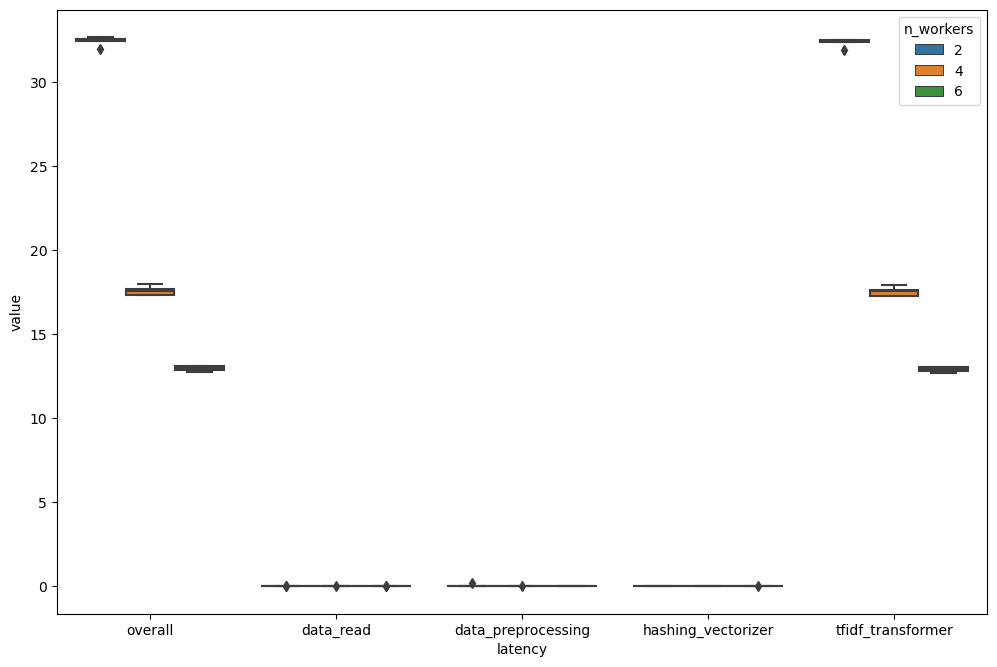

CPU times: user 18.7 s, sys: 4 s, total: 22.7 s
Wall time: 7min 11s


sample_run                    overall                 data_read  \
                mean       std count       mean       std count      mean   
n_workers                                                                   
2                  2  1.581139     5  32.459161  0.273235     5  0.020671   
4                  2  1.581139     5  17.596522  0.264940     5  0.023048   
6                  2  1.581139     5  12.972659  0.169706     5  0.024137   

                          data_preprocessing  ...       hashing_vectorizer  \
                std count               mean  ... count               mean   
n_workers                                     ...                            
2          0.002267     5           0.058895  ...     5           0.003291   
4          0.001958     5           0.027917  ...     5           0.003745   
6          0.004151     5           0.028502  ...     5           0.003518   

                          tfidf_transformer                    nrows       \
                std count              mean       std count     mean  std   
n_workers                                                                   
2          0.000320     5         32.375202  0.249851     5  7004147  0.0   
4          0.000736     5         17.540150  0.259570     5  7004147  0.0   
6          0.000553     5         12.914661  0.169950     5  7004147  0.0   

                 
          count  
n_workers        
2             5  
4             5  
6             5  

[3 rows x 21 columns]

In [12]:
%%time
#parquet_path = 's3://amazon-reviews-pds/parquet/product_category=Camera/*.parquet'
dataset = "PC"
parquet_path = f'./data/product_category={dataset}'
model_kwargs = {"text_preprocessor":text_preprocessor}
samples = 5
worker_counts = [2,4,6]
result_path = f"./results/result_poc_nlp_dask_{dataset}_nonpersist.pkl"
performance_numbers(client, parquet_path=parquet_path, worker_counts=worker_counts, samples=samples, result_path=result_path, persist_flag=False)
data, melt_data = visualize_data(result_path)        
groupy = data.groupby("n_workers").agg(['mean', 'std', 'count'])
groupy

In [13]:
client.close()
cluster.close()